In [42]:
import numpy as np
import time
import pandas as pd
from scipy.stats import qmc, norm
import math
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as mp

In [100]:
S0 = 100
K = 100
r = 0.05
sigma = 0.1

mu_jump = -0.005
sigma_jump = 0.1
lambda_jump = 0.75

kappa = np.exp(mu_jump + 0.5 * sigma_jump ** 2) - 1

In [44]:
T = 1
N = 256
dt = T / N
sqrt_dt = np.sqrt(dt)

### Control Variates

In [106]:
def geom_control_function(S0, r, sigma, T, N):
    
    n_pil = 1000
    np.random.seed(1)

    res_control_pilot = np.zeros(n_pil)
    res_sample_pilot = np.zeros(n_pil)

    for i in range(n_pil):
        S = np.zeros(N + 1)
        S[0] = S0
        
        U = np.random.normal()
        J = 1
        
        if U < lambda_jump * dt:
            J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)

        for j in range(1, N + 1):
            S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) * dt + (sigma * math.sqrt(dt) * np.random.normal(0, 1)) + (J-1))
           # S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
           #                          sigma * math.sqrt(dt) * np.random.normal(0, 1))

        S = np.delete(S, 0)

        geo_avg = np.exp(np.log(S).mean())
        arith_avg = S.mean()

        res_control_pilot[i] = np.exp(-1 * r * T) * max(geo_avg - K, 0)
        res_sample_pilot[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)  
    
    a = np.log(S0) + (r - (sigma**2 / 2)) * T * (N + 1) / (2*N)
    b = (sigma**2) * (T * (N+1) * (2*N + 1)) / (6 * N*N)

    d1 = (-1 * np.log(K) + a + b) / math.sqrt(b)
    d2 = d1 - math.sqrt(b)

    phi_d1 = norm.cdf(d1)
    phi_d2 = norm.cdf(d2)

    mu_g_analytic = np.exp(-1 * r * T) * (np.exp(a + b/2)*phi_d1 - K * phi_d2)
    beta_estimate = np.cov(res_control_pilot, res_sample_pilot)[0][1] / np.var(res_control_pilot)
    
    return mu_g_analytic, beta_estimate

def european_control_function(S0, r, sigma, T, N):
    
    def black_scholes_call(S0, K, T, r, sigma):
        # Calculate d1 and d2
        d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # Calculate the call option price using the Black-Scholes formula
        call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

        return call_price
    
    n_pil = 1000
    np.random.seed(1)

    res_control_pilot = np.zeros(n_pil)
    res_sample_pilot = np.zeros(n_pil)

    for i in range(n_pil):
        S = np.zeros(N + 1)
        S[0] = S0

        for j in range(1, N + 1):
            S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) + (sigma * math.sqrt(dt) * np.random.normal(0, 1)) + (J-1))
            #S[j] = S[j-1] * math.exp((r - (sigma*sigma)/2) * dt + 
            #                         sigma * math.sqrt(dt) * np.random.normal(0, 1))

        S = np.delete(S, 0)

        #geo_avg = np.exp(np.log(S).mean())
        euro = S[-1]
        arith_avg = S.mean()

        res_control_pilot[i] = np.exp(-1 * r * T) * max(euro - K, 0)
        res_sample_pilot[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)  
        
        mu_g_analytic = black_scholes_call(S0, K, T, r, sigma)
        beta_estimate = np.cov(res_control_pilot, res_sample_pilot)[0][1] / np.var(res_control_pilot)

        return mu_g_analytic, beta_estimate
    

def control_variates(n):
    
    mu_g_analytic, beta_estimate = geom_control_function(S0, r, sigma, T, N)
    
    result = np.zeros(n)
    result_control = np.zeros(n)
    stocks = np.zeros(n)
    
    for i in range(n):
        S = np.zeros(N + 1)
        S[0] = S0
        
        U = np.random.normal()
        J = 1
        
        if U < lambda_jump * dt:
            J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)

        for j in range(1, N + 1):
            S[j] = S[j-1] * (1 + (r - lambda_jump * kappa) * dt + (sigma * math.sqrt(dt) * np.random.normal(0, 1)) + (J-1))

        S = np.delete(S, 0)

        geo_avg = np.exp(np.log(S).mean())
        arith_avg = S.mean()

        control = np.exp(-1 * r * T) * max(geo_avg - K, 0)
        result[i] = np.exp(-1 * r * T) * max(arith_avg - K, 0)
        result_control[i] = result[i] + beta_estimate * (mu_g_analytic - control)
        stocks[i] = S[-1]
        
    return result_control, result, stocks

In [107]:
_, res, stock = control_variates(1000)
res.mean()

3.6721456808246047

In [46]:
def payoff_european(S, K, call = True):
    if call:
        return np.maximum(S[-1] - K, 0)
    else:
        return np.maximum(K - S[-1], 0)

def payoff_asian(S, K, likelihoods = None, call = True):
    if call:
        return np.maximum(S.mean(axis = 0) - K, 0)
    else:
        return np.maximum(K - S.mean(axis = 0), 0)
    
def payoff_asian_importance(S, likelihood_ratio = 0.5, call=True):
    raw_payoff = np.maximum(S.mean(axis=0) - K, 0) if call else np.maximum(K - S.mean(axis=0), 0)
    return raw_payoff * likelihood_ratio

In [47]:
def control_variate_asian_asset(S_i, n):
    Z = np.random.normal(size=n)
    S_new = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    return S_new

def payoff_asian_cv(S):
    """
    Returns control variate adjusted payoff.
    S: shape (N, M) array of asset prices
    """
    N, M = S.shape
    avg_price = S.mean(axis=1)
    V = np.exp(-r * T) * np.maximum(avg_price - K, 0)

    S_sum = S.sum(axis=1)
    S_star = np.mean(S_sum)

    cov = np.cov(V, S_sum, bias=True)[0, 1]
    var = np.var(S_sum)
    alpha = cov / var if var > 0 else 0.0

    V_cv = V - alpha * (S_sum - S_star)
    return V_cv


In [48]:
def quasi_brownian_asset(S_i, n):
    Z = quasi_random_normal_samples(n)
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def brownian_asset(S_i, n):
    Z = np.random.normal(loc=0, scale = 1, size = n)    
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def antithetic_brownian_asset(S_i, n):
    Z1 = np.random.normal(size = (int) (n/2))
    Z2 = -Z1
    
    Z = np.empty((Z1.size + Z2.size,), dtype=Z1.dtype)
    Z[0::2] = Z1
    Z[1::2] = Z2
    
    return S_i * (1 + r * dt + sigma * sqrt_dt * Z)

def brownian_asset_importance_sampling(S_i, n, mu_shift=0.2):
    Z = np.random.normal(loc=mu_shift, size=n)
    S_path = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    
    # Likelihood ratio for each Z sample
    likelihood_ratio = np.exp(-mu_shift * Z + 0.5 * mu_shift**2)
    
    return S_path, likelihood_ratio

In [49]:
def mc_asian_importance_sampling(S0, K, r, sigma, dt, mu_shift=0.1, n_sim = 1, n_steps = 1, ):
    payoffs = []
    for _ in range(n_sim):
        Z = np.random.normal(loc=mu_shift, scale=1.0, size=n_steps)
        S_path = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z))
        S_path = np.insert(S_path, 0, S0)
        avg_price = np.mean(S_path)
        payoff = max(avg_price - K, 0)

        # Likelihood ratio (change of measure)
        likelihood = np.exp(-mu_shift * np.sum(Z) + 0.5 * mu_shift**2 * n_steps)
        weighted_payoff = np.exp(-r * T) * payoff * likelihood
        payoffs.append(weighted_payoff)
        
    return np.mean(payoffs), np.std(payoffs) / np.sqrt(n_sim)

In [50]:
def payoff_asian_importance(S, random_sum, mu_shift, n_steps):
    raw_payoff = np.maximum(S.mean(axis=0) - K, 0)
    
    likelihoods = -mu_shift * random_sum + 0.5 * mu_shift**2 * n_steps
    
    return raw_payoff * np.exp(likelihoods)

def importance_sampled_normal(size = 0, mu_shift=0.5):
    Z_shifted = np.random.normal(loc=mu_shift, scale=1)
    likelihood_ratio = np.exp(-mu_shift * Z_shifted + 0.5 * mu_shift**2)
    
    return Z_shifted, likelihood_ratio

def GBM_importance(S_i, r, sigma, dt, sqrt_dt, mu_shift=0.5):
    Z, likelihood_ratio = importance_sampled_normal(size=1, mu_shift=mu_shift)
    S_new = S_i * (1 + r * dt + sigma * sqrt_dt * Z)
    return S_new, Z

def run_monte_carlo_IS(S0, K, r, sigma, T, N, n, payoff_function, method, mu_shift=0.5):
    S = np.full((n, N), S0)
    likelihoods = np.ones(n)

    for i in range(1, N):
        S[:, i], new_likelihoods = method(S[:, i - 1], n, mu_shift=mu_shift)
        likelihoods *= new_likelihoods  # Multiply likelihoods across time steps

    print(S[:, -1])
        
    payoffs = payoff_function(S, likelihoods)
    return np.exp(-r * T) * payoffs.mean(), payoffs.std() / np.sqrt(n)


### Importance Sampling

In [67]:
def quasi_Sobol(n, dim):
    sampler = qmc.Sobol(d=dim, scramble=True)
    u = sampler.random(n)
    z = norm.ppf(u)
    return z

def standard_normal(N, M):
    return np.random.normal(loc = 0, scale = 1.0, size = (N, M))
    

def GBM(S, r, sigma, dt, sqrt_dt, Z):
    return S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z)

def MertonJump(S, r, sigma, dt, sqrt_dt, Z):
    
    U = np.random.uniform()
    J = 1
    
    if U < lambda_jump * dt:
        J = np.random.lognormal(mean = mu_jump, sigma = sigma_jump)     
        
    return S * (1 + r * dt + sigma * sqrt_dt * Z + (J-1))
    

def antithetic_GBM(S, r, sigma, dt, sqrt_dt, Z):
    return S * np.exp((r - 0.5 * sigma**2) * dt - sigma * sqrt_dt * Z)

def gbm_faster(S, r, sigma, dt, sqrt_dt):
    return S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * np.random.normal())


def run_monte_carlo(S0, K, r, sigma, T, M, N, payoff_function, method = GBM, sample_method = standard_normal, antithetic = True, mu_shift = 0):
    
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    dimension = 1
    
    if antithetic:
        dimension = 2
    
    payoffs = np.zeros( (int) (dimension * N) )
    random_sum = 0
    
    if sample_method == quasi_Sobol:
        Z = sample_method(N, M)
    
    for i in range(N):
        S = S0
        path = [S]
        for j in range(M):
            
            if sample_method == quasi_Sobol:
                S = method(S, r, sigma, dt, sqrt_dt, Z[i, j])
            elif mu_shift != 0:
                S, new_likelihoods = method(S, r, sigma, dt, sqrt_dt, mu_shift=mu_shift)
                random_sum += new_likelihoods
                #print(S)
                
            else:
                S = method(S, r, sigma, dt, sqrt_dt, np.random.normal())
                #print(S)
                
            #S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z[i, j])
            path.append(S)
        
        if mu_shift != 0:
            payoffs[i] = payoff_function(np.array(path), random_sum, mu_shift, N)
        else:
            payoffs[i] = payoff_function(np.array(path), K)

    
    if antithetic:
        
        for i in range(N):
            S = S0
            path = [S]
            for j in range(M):
                
                if sample_method == quasi_Sobol:
                    S = method(S, r, sigma, dt, sqrt_dt, Z[i, j])
                else:
                    S = method(S, r, sigma, dt, sqrt_dt, np.random.normal())
                    
                #S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z[i, j])
                path.append(S)


            payoffs[i + N] = payoff_function(np.array(path), K)
    
        
    price = np.exp(-r * T) * payoffs
    return np.mean(price), np.std(price) / np.sqrt(dimension * N)


def run_experiment(method = GBM, payoff_function = payoff_asian, num_trials = 10, base = 2, sample_method = standard_normal, antithetic = False, cv = False, baseline = False, mu_shift = 0, K = 100, r = 0.05):
       
    min_samples = 3
        
    n_list = np.arange(min_samples, num_trials, 1)
    v = np.zeros_like(n_list, dtype = np.float64)
    std_devs = np.zeros_like(n_list, dtype = np.float64)
    times = np.zeros_like(n_list, dtype = np.float64)

    for i in range(len(n_list)):
        start_time = time.time()
        n = n_list[i]
        
        if mu_shift != 0:
            
            v[i], std_devs[i] = mc_asian_importance_sampling(S0, K, r, sigma, dt, mu_shift=mu_shift, n_sim = base ** n, n_steps = N)
            
        elif cv:
            cv_samples, no_cv_samples = control_variates(base ** n)
            
            if baseline:
                v[i] = no_cv_samples.mean()
                std_devs[i] = no_cv_samples.std() / np.sqrt(base ** n)
            
            v[i] = cv_samples.mean()
            std_devs[i] = cv_samples.std() / np.sqrt(base ** n)
        else:
            v[i], std_devs[i] = run_monte_carlo(S0, K, r, sigma, T, N, base**n, 
                                                payoff_function = payoff_function, method = method,
                                                sample_method = sample_method, antithetic = antithetic, mu_shift = mu_shift)

        times[i] = time.time() - start_time
        
    return (v, std_devs, times)

def format_data(data, decay = 2):
    df = pd.DataFrame(np.array(data).T)
    df.index = decay ** (df.index + 3)
    df.index.name = "Num Samples"
    df.columns = {"Option Price (V)", "MOE", "Runtime"}
    
    return df

def plot_results(data, title, true_v = 3.6436):
    mean = data[0]
    margin = data[1]

    x = np.arange(len(mean)) + 3

    mp.plot(x, mean, label='Mean', color='blue')
    mp.fill_between(x, mean - margin, mean + margin, color='blue', alpha=0.2, label='Margin of Error')
    
    mp.axhline(y=true_v, color='red', linestyle=':', linewidth=2, label='Estimated Price')

    # Styling
    mp.title(title)
    mp.xlabel('Number of Simulations (Log Scale)')
    mp.ylabel('Option Value (V)')
    mp.legend(loc='lower right')
    mp.grid(True)
    mp.show()
    

In [15]:
format_data(run_experiment(baseline = True, num_trials = 7, base = 10))

,Runtime,MOE,Option Price (V)
Num Samples,,,
8,3.5669,0.1329,2.0132
16,3.6661,0.0426,20.5676
32,3.6262,0.0133,203.2434
64,3.6436,0.0042,"10,614.0174"


In [70]:
jump_vanilla = run_experiment(MertonJump, payoff_function = payoff_asian, num_trials = 15, base = 2, r = 0.05 - lambda_jump * kappa)

In [71]:
format_data(jump_vanilla)

,Option Price (V),Runtime,MOE
Num Samples,,,
8,5.5078,1.5720,0.0143
16,3.8144,0.9319,0.0300
32,3.6681,0.7382,0.0866
64,4.1935,0.9928,0.1974
128,3.8852,0.4081,0.4166
256,4.4935,0.3565,0.8686
512,4.4382,0.2690,1.6733
1024,4.3304,0.1720,3.2474
2048,4.1094,0.1179,7.0746


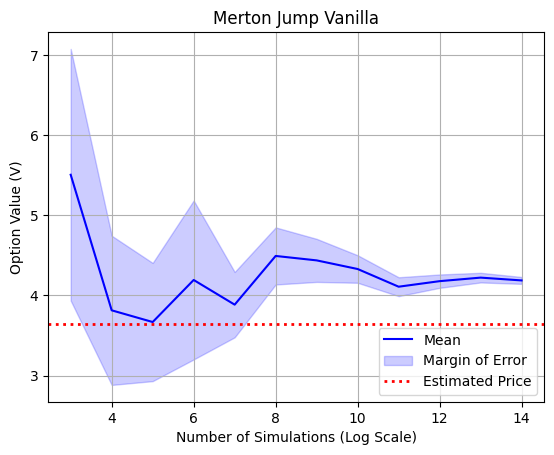

In [73]:
plot_results(jump_vanilla, title = "Merton Jump Vanilla")

In [56]:
gbm_base = run_experiment(GBM, payoff_function = payoff_asian, num_trials = 15, base = 2)

In [57]:
format_data(gbm_base)

,Option Price (V),Runtime,MOE
Num Samples,,,
8,1.7514,0.8519,0.0100
16,3.6576,0.7863,0.0148
32,3.0854,0.5590,0.0533
64,3.1919,0.5005,0.1354
128,3.6095,0.4016,0.2439
256,3.3459,0.2357,0.5267
512,3.7535,0.1890,1.0668
1024,3.6450,0.1297,2.0729
2048,3.6964,0.0966,3.9699


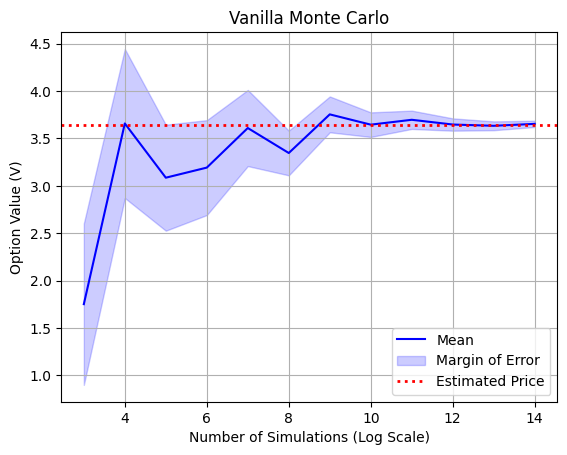

In [58]:
plot_results(gbm_base, title = "Vanilla Monte Carlo")

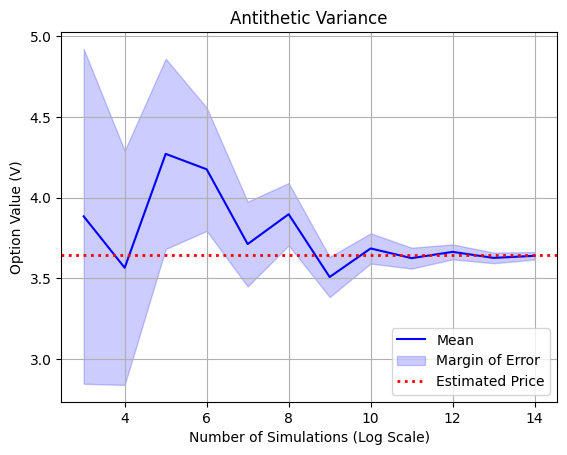

In [354]:
antithetic_GBM_data = run_experiment(GBM, payoff_function = payoff_asian, antithetic = True, num_trials = 15, base = 2)
format_data(antithetic_GBM_data)
plot_results(antithetic_GBM_data, title = "Antithetic Variance")

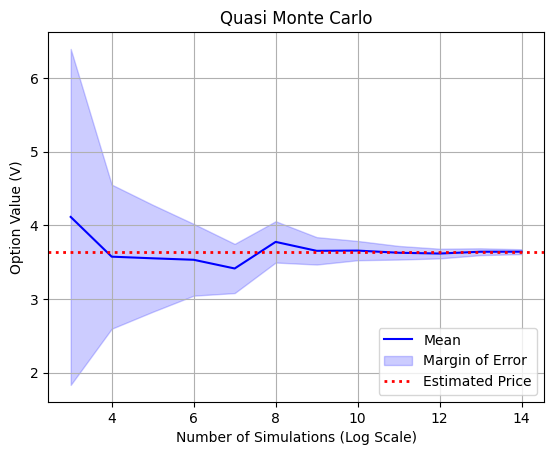

In [355]:
sobol_gbm = run_experiment(GBM, payoff_function = payoff_asian, sample_method = quasi_Sobol, num_trials = 15, base = 2)
format_data(sobol_gbm)
plot_results(sobol_gbm, "Quasi Monte Carlo")

In [77]:
sobol_jump = run_experiment(MertonJump, payoff_function = payoff_asian, sample_method = quasi_Sobol, num_trials = 15, base = 2)
format_data(sobol_jump)

,Option Price (V),Runtime,MOE
Num Samples,,,
8,3.7888,1.2807,0.1317
16,2.7589,1.0059,0.1278
32,4.5343,0.9799,0.1626
64,4.6648,0.8304,0.2122
128,4.5738,0.4405,0.4034
256,3.8748,0.3277,0.7411
512,4.4744,0.2523,1.3214
1024,4.2060,0.1668,2.7306
2048,4.3044,0.1249,5.4378


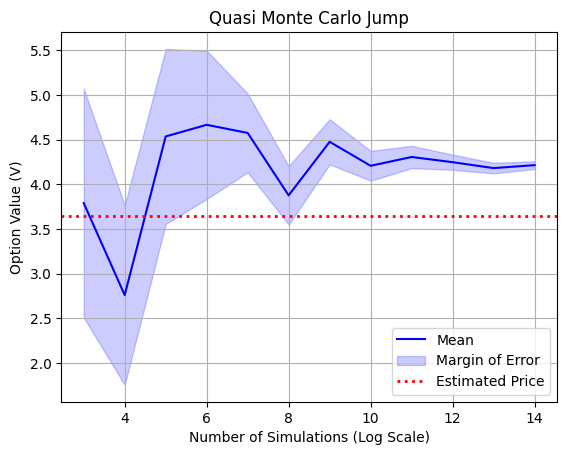

In [78]:
plot_results(sobol_jump, "Quasi Monte Carlo Jump")

In [356]:
control_variates_geom = run_experiment(cv = True, num_trials = 15, base = 2)

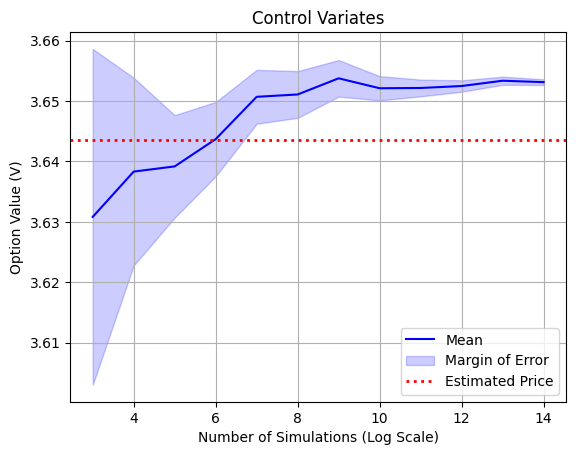

In [357]:
format_data(control_variates_geom)
plot_results(control_variates_geom, title = "Control Variates")

In [87]:
control_variates_geom_jump = run_experiment(MertonJump, cv = True, num_trials = 9, base = 2)

In [89]:
format_data(control_variates_geom_jump)

,Option Price (V),Runtime,MOE
Num Samples,,,
8,"-3,576,395,796,428,126,961,654,562,816.0000","3,344,596,372,411,555,720,911,126,528.0000",1.5824
16,"-1,788,259,916,762,774,425,007,292,416.0000","1,731,017,214,591,412,627,180,617,728.0000",1.6784
32,"-52,779,423,372,128,965,592,300,388,352.0000","51,047,335,894,386,252,852,829,880,320.0000",1.7426
64,"-26,392,874,129,110,461,200,887,447,552.0000","25,735,899,847,779,801,720,359,485,440.0000",1.8354
128,"-19,234,233,266,907,119,641,769,803,776.0000","14,207,986,187,654,604,346,787,627,008.0000",1.9574
256,"-9,646,556,013,835,655,605,735,391,232.0000","7,129,253,482,952,871,726,265,925,632.0000",2.1230


In [ ]:
plot_results(control_variates_geom_jump, title = "Control Variates Jump")

In [358]:
importance_GBM_data = run_experiment(method=GBM_importance, 
                      payoff_function=payoff_asian_importance, 
                      sample_method = importance_sampled_normal, 
                      mu_shift=0.05, num_trials=17, base=2,
                     K = 110)

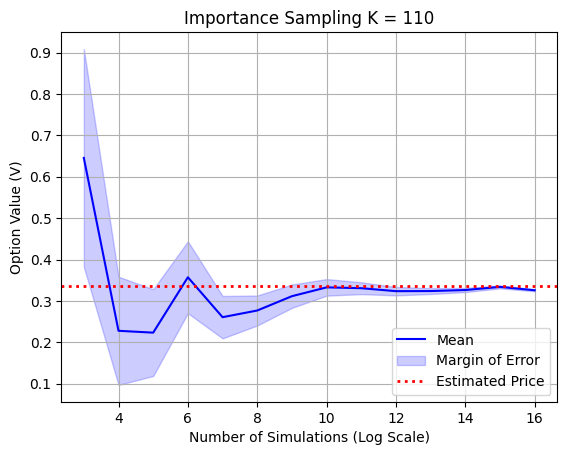

In [364]:
format_data(importance_GBM_data)
plot_results(importance_GBM_data, title = "Importance Sampling K = 110", true_v = 0.3359)

In [367]:
standard_gbm_K110 = gbm_base = run_experiment(GBM, payoff_function = payoff_asian, num_trials = 17, base = 2, K=110)
format_data(standard_gbm_K110)

,MOE,Option Price (V),Runtime
Num Samples,,,
8,0.0379,0.0355,0.0043
16,0.3701,0.2735,0.0075
32,0.0321,0.0316,0.0228
64,0.2627,0.1247,0.0253
128,0.2771,0.0872,0.0996
256,0.2504,0.0625,0.2335
512,0.3230,0.0538,0.4147
1024,0.2658,0.0335,0.8092
2048,0.3053,0.0263,1.8548


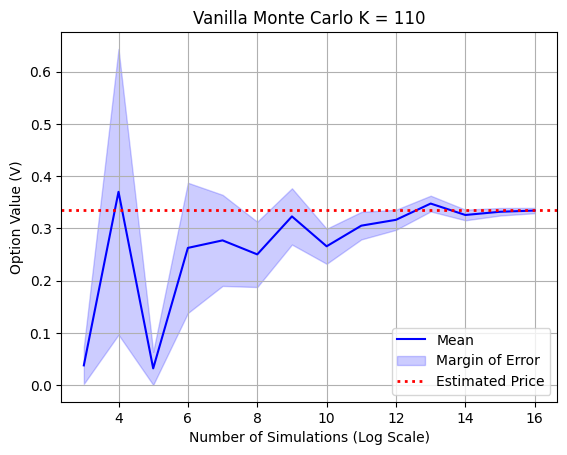

In [368]:
plot_results(standard_gbm_K110, title = "Vanilla Monte Carlo K = 110", true_v = 0.3359)

In [318]:
antithetic_GBM_Sobol = run_experiment(GBM, payoff_function = payoff_asian, 
                                sample_method = quasi_Sobol,
                                antithetic = True, num_trials = 15, base = 2)

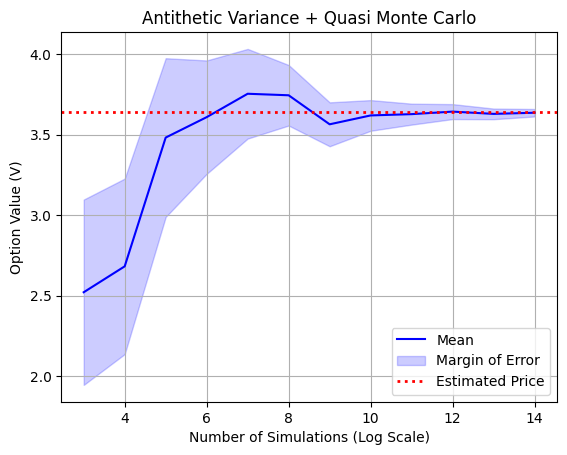

In [362]:
format_data(antithetic_GBM_Sobol)
plot_results(antithetic_GBM_Sobol, title = "Antithetic Variance + Quasi Monte Carlo")